# Model Definition

**Part 1 of Model Definition**

This part of the code:

- Downloads and loads the CIFAR-10 dataset, as required.

- Applies data augmentation (horizontal flip, random crop, normalization) to improve generalization.

- Uses DataLoader to efficiently batch and shuffle data for training and validation.

- Utilizes pin_memory and multiple workers for performance optimization.

This should satisfy Task 1


---



**Part 2 of Model Definition**

This section implements the model as described in the coursework slides:

- Stem: A convolutional layer followed by BatchNorm, ReLU, and MaxPooling.

- Backbone: Multiple blocks (B1–B3) consisting of:

- An expert branch that applies Spatial Average Pooling followed by FC1 → ReLU → FC2 → Softmax to compute expert weights.

- Multiple convolutional branches (K=4) whose outputs are weighted and summed based on the expert vector a.

- Classifier: Uses Global Average Pooling and a final fully connected layer to output predictions for 10 classes.

This part should satisfy Task 2 (a more detailed explanation of the model is described in another part of this notebook)

In [1]:
# --- PART 1 OF CODE ---
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

# Enable optimized GPU performance if CUDA GPU is available
cudnn.benchmark = True

# Data augmentation to improve model generalization and avoid overfitting
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),     # Randomly crop images with padding
    transforms.ToTensor(),                    # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5),     # Normalize images to range [-1, 1]
                         (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset for training and validation
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use entire dataset without splitting further
trainset, _ = torch.utils.data.random_split(trainset, [50000, 0])

# Define optimized DataLoaders with larger batch size for faster training
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)


# --- PART 2 OF CODE ---

# Define the ExpertBranch used within the backbone blocks
class ExpertBranch(nn.Module):
    def __init__(self, in_channels, K=4, reduction=4):
        super(ExpertBranch, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)  # Pool input to single spatial point, Spatial Average Pool
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)  # Reduce dimensionality
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(in_channels // reduction, K)  # Predict weighting for K branches
        self.softmax = nn.Softmax(dim=1)  # Normalize predictions to sum to 1

    def forward(self, x):
        x = self.pool(x).view(x.size(0), -1)  # Pool and flatten
        x = self.relu(self.fc1(x))            # Reduce dimensions and activate
        x = self.softmax(self.fc2(x))         # Predict and normalize
        return x

# Define BackboneBlock that dynamically combines convolutional outputs
class BackboneBlock(nn.Module):
    def __init__(self, in_channels, K=4):
        super(BackboneBlock, self).__init__()
        self.expert_branch = ExpertBranch(in_channels, K)
        # Define multiple convolutional layers (experts)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1) for _ in range(K)
        ])
        self.bn = nn.BatchNorm2d(in_channels)  # Batch normalization
        self.relu = nn.ReLU()                  # Activation function

    def forward(self, x):
        a = self.expert_branch(x)  # Expert weighting predictions
        # Dynamically combine outputs of each convolution using expert weights
        out = sum(a[:, i].view(-1, 1, 1, 1) * self.convs[i](x) for i in range(len(self.convs)))
        out = self.relu(self.bn(out))  # Normalize and activate output
        return out

# Define complete CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # Stem layer (initial feature extraction)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)

        # Backbone consists of 3 sequential Backbone Blocks
        self.backbone1 = BackboneBlock(64, K=4)
        self.pool1 = nn.MaxPool2d(2)
        self.backbone2 = BackboneBlock(64, K=4)
        self.pool2 = nn.MaxPool2d(2)
        self.backbone3 = BackboneBlock(64, K=4)
        self.pool3 = nn.MaxPool2d(2)

        # Global average pooling and classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.pool1(self.backbone1(x))
        x = self.pool2(self.backbone2(x))
        x = self.pool3(self.backbone3(x))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x


100%|██████████| 170M/170M [00:04<00:00, 42.0MB/s]


# Describing the model

**ExpertBranch**

Purpose: Let the model decide dynamically how much to rely on each expert convolution.

This module predicts a weight vector a = [a₁, ..., aₖ] for combining multiple convolutional outputs.

Explanation of how it works:

- AdaptiveAvgPool2d(1): Applies spatial average pooling to collapse the spatial dimensions of the feature map, resulting in a vector of shape [batch_size, channels].

- FC1 → ReLU → FC2: Reduces the vector's dimensionality and transforms it into a vector of length K (number of expert branches).

- Softmax: Ensures the weights a sum to 1, so they can be used to combine outputs from different experts.


---



**BackboneBlock – Weighted Combination of Expert Convolutions**

Purpose: Enables the network to adaptively mix different convolutional filters, allowing flexibility and richer representations.

Each backbone block uses multiple convolutional experts, weighted using ExpertBranch.

Explanation of how it works:

- The input is passed to the ExpertBranch to get the vector a.

- The same input is passed through K convolutional layers.

- Each output is multiplied by its corresponding weight aₖ, then summed together.

- The combined output is passed through BatchNorm and ReLU.



---

**CNN – The Complete Model (Stem → Backbone → Classifier)**

Purpose: End-to-end classification network that uses dynamic blocks for flexible, learned feature extraction.

Structure:

- Stem: One initial convolution + batch norm + ReLU + pooling to begin feature extraction.

- Backbone:

  - Three BackboneBlocks.

  - Each block is followed by a pooling layer to reduce spatial dimensions.

- Classifier:

  - A Global Average Pooling reduces the feature map to a single vector.

  - A fully connected layer maps this vector to 10 output classes.
---


# Training the CNN + Results

**Create the Loss and Optimizer**

```
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

```
The code uses:
- CrossEntropyLoss for multi-class classification.

- Adam optimizer, chosen for its adaptive learning rate capabilities.

- A StepLR scheduler is applied to reduce the learning rate every 5 epochs (LR is halved by multiplying it by the gamma=0.5), improving stability and final accuracy.

This part should satisfy Task 3.

---
**Training Script**

```
def train_model(...): ...
train_losses, test_losses, train_accs, test_accs = train_model(...)

```
The code implements a complete training loop including:

- Forward pass

- Backpropagation using GradScaler for mixed precision

- Evaluation on validation set

- Tracks and logs training/test accuracy and loss after each epoch.

- Uses tqdm for real-time progress bars and time estimation.

```
# Plotting curves
plt.plot(...)  # Loss and Accuracy Curves

```
Additionally, it returns and plots:
- the curves for evolution loss at the end of training
- the curves for the evolution of training and validation (test) accuracies.




<ipython-input-2-884f0854e880>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision training for speedup
Epoch 1/50:   0%|          | 0/196 [00:00<?, ?it/s]<ipython-input-2-884f0854e880>:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 196/196 [00:22<00:00,  8.84it/s, acc=47.6, loss=0.00559]


Epoch 1: Train Acc=47.57% | Test Acc=54.58%


Epoch 2/50: 100%|██████████| 196/196 [00:19<00:00,  9.90it/s, acc=62.9, loss=0.00406]


Epoch 2: Train Acc=62.93% | Test Acc=64.94%


Epoch 3/50: 100%|██████████| 196/196 [00:18<00:00, 10.49it/s, acc=69.1, loss=0.00342]


Epoch 3: Train Acc=69.12% | Test Acc=66.76%


Epoch 4/50: 100%|██████████| 196/196 [00:19<00:00, 10.15it/s, acc=72.3, loss=0.00309]


Epoch 4: Train Acc=72.31% | Test Acc=69.28%


Epoch 5/50: 100%|██████████| 196/196 [00:18<00:00, 10.32it/s, acc=74.3, loss=0.00287]


Epoch 5: Train Acc=74.35% | Test Acc=73.64%


Epoch 6/50: 100%|██████████| 196/196 [00:19<00:00,  9.97it/s, acc=76.1, loss=0.00269]


Epoch 6: Train Acc=76.10% | Test Acc=72.31%


Epoch 7/50: 100%|██████████| 196/196 [00:19<00:00, 10.08it/s, acc=77.2, loss=0.00256]


Epoch 7: Train Acc=77.25% | Test Acc=68.60%


Epoch 8/50: 100%|██████████| 196/196 [00:18<00:00, 10.58it/s, acc=78.3, loss=0.00246]


Epoch 8: Train Acc=78.28% | Test Acc=75.53%


Epoch 9/50: 100%|██████████| 196/196 [00:18<00:00, 10.51it/s, acc=81.5, loss=0.00209]


Epoch 9: Train Acc=81.49% | Test Acc=79.03%


Epoch 10/50: 100%|██████████| 196/196 [00:19<00:00, 10.03it/s, acc=82.1, loss=0.00202]


Epoch 10: Train Acc=82.13% | Test Acc=78.76%


Epoch 11/50: 100%|██████████| 196/196 [00:19<00:00,  9.97it/s, acc=82.6, loss=0.00195]


Epoch 11: Train Acc=82.62% | Test Acc=79.73%


Epoch 12/50: 100%|██████████| 196/196 [00:18<00:00, 10.36it/s, acc=83.3, loss=0.00189]


Epoch 12: Train Acc=83.30% | Test Acc=79.56%


Epoch 13/50: 100%|██████████| 196/196 [00:20<00:00,  9.76it/s, acc=83.5, loss=0.00186]


Epoch 13: Train Acc=83.46% | Test Acc=81.49%


Epoch 14/50: 100%|██████████| 196/196 [00:19<00:00, 10.24it/s, acc=83.9, loss=0.00181]


Epoch 14: Train Acc=83.90% | Test Acc=80.03%


Epoch 15/50: 100%|██████████| 196/196 [00:19<00:00,  9.82it/s, acc=83.9, loss=0.0018]


Epoch 15: Train Acc=83.88% | Test Acc=79.79%


Epoch 16/50: 100%|██████████| 196/196 [00:20<00:00,  9.76it/s, acc=84.4, loss=0.00177]


Epoch 16: Train Acc=84.37% | Test Acc=81.29%


Epoch 17/50: 100%|██████████| 196/196 [00:19<00:00,  9.83it/s, acc=86.3, loss=0.00156]


Epoch 17: Train Acc=86.27% | Test Acc=82.44%


Epoch 18/50: 100%|██████████| 196/196 [00:18<00:00, 10.32it/s, acc=86.9, loss=0.0015]


Epoch 18: Train Acc=86.86% | Test Acc=82.80%


Epoch 19/50: 100%|██████████| 196/196 [00:18<00:00, 10.42it/s, acc=87.2, loss=0.00145]


Epoch 19: Train Acc=87.23% | Test Acc=83.01%


Epoch 20/50: 100%|██████████| 196/196 [00:19<00:00,  9.95it/s, acc=87, loss=0.00145]


Epoch 20: Train Acc=86.97% | Test Acc=83.21%


Epoch 21/50: 100%|██████████| 196/196 [00:20<00:00,  9.73it/s, acc=87.5, loss=0.00141]


Epoch 21: Train Acc=87.47% | Test Acc=82.50%


Epoch 22/50: 100%|██████████| 196/196 [00:19<00:00,  9.83it/s, acc=87.5, loss=0.00141]


Epoch 22: Train Acc=87.50% | Test Acc=83.35%


Epoch 23/50: 100%|██████████| 196/196 [00:18<00:00, 10.36it/s, acc=87.7, loss=0.00139]


Epoch 23: Train Acc=87.69% | Test Acc=83.69%


Epoch 24/50: 100%|██████████| 196/196 [00:18<00:00, 10.32it/s, acc=87.8, loss=0.00135]


Epoch 24: Train Acc=87.80% | Test Acc=83.81%


Epoch 25/50: 100%|██████████| 196/196 [00:20<00:00,  9.60it/s, acc=88.9, loss=0.00124]


Epoch 25: Train Acc=88.93% | Test Acc=84.55%


Epoch 26/50: 100%|██████████| 196/196 [00:20<00:00,  9.78it/s, acc=89.2, loss=0.00121]


Epoch 26: Train Acc=89.23% | Test Acc=84.51%


Epoch 27/50: 100%|██████████| 196/196 [00:19<00:00,  9.85it/s, acc=89.6, loss=0.00117]


Epoch 27: Train Acc=89.65% | Test Acc=84.85%


Epoch 28/50: 100%|██████████| 196/196 [00:19<00:00,  9.85it/s, acc=89.6, loss=0.00117]


Epoch 28: Train Acc=89.60% | Test Acc=84.58%


Epoch 29/50: 100%|██████████| 196/196 [00:19<00:00, 10.21it/s, acc=89.8, loss=0.00114]


Epoch 29: Train Acc=89.79% | Test Acc=85.15%


Epoch 30/50: 100%|██████████| 196/196 [00:19<00:00, 10.28it/s, acc=89.9, loss=0.00113]


Epoch 30: Train Acc=89.87% | Test Acc=85.01%


Epoch 31/50: 100%|██████████| 196/196 [00:19<00:00, 10.15it/s, acc=90, loss=0.00112]


Epoch 31: Train Acc=89.97% | Test Acc=84.74%


Epoch 32/50: 100%|██████████| 196/196 [00:19<00:00, 10.07it/s, acc=90.1, loss=0.00111]


Epoch 32: Train Acc=90.12% | Test Acc=85.15%


Epoch 33/50: 100%|██████████| 196/196 [00:19<00:00, 10.09it/s, acc=90.9, loss=0.00102]


Epoch 33: Train Acc=90.90% | Test Acc=85.36%


Epoch 34/50: 100%|██████████| 196/196 [00:19<00:00, 10.30it/s, acc=91, loss=0.00102]


Epoch 34: Train Acc=91.05% | Test Acc=85.61%


Epoch 35/50: 100%|██████████| 196/196 [00:18<00:00, 10.40it/s, acc=91.2, loss=0.00101]


Epoch 35: Train Acc=91.21% | Test Acc=85.85%


Epoch 36/50: 100%|██████████| 196/196 [00:19<00:00,  9.89it/s, acc=91.2, loss=0.000988]


Epoch 36: Train Acc=91.17% | Test Acc=85.32%


Epoch 37/50: 100%|██████████| 196/196 [00:19<00:00,  9.84it/s, acc=91.2, loss=0.000986]


Epoch 37: Train Acc=91.19% | Test Acc=85.57%


Epoch 38/50: 100%|██████████| 196/196 [00:20<00:00,  9.36it/s, acc=91.2, loss=0.000979]


Epoch 38: Train Acc=91.24% | Test Acc=85.77%


Epoch 39/50: 100%|██████████| 196/196 [00:19<00:00, 10.31it/s, acc=91.7, loss=0.000948]


Epoch 39: Train Acc=91.67% | Test Acc=85.37%


Epoch 40/50: 100%|██████████| 196/196 [00:18<00:00, 10.43it/s, acc=91.6, loss=0.000948]


Epoch 40: Train Acc=91.63% | Test Acc=85.72%


Epoch 41/50: 100%|██████████| 196/196 [00:19<00:00,  9.93it/s, acc=91.9, loss=0.000918]


Epoch 41: Train Acc=91.87% | Test Acc=85.93%


Epoch 42/50: 100%|██████████| 196/196 [00:19<00:00,  9.91it/s, acc=92, loss=0.000902]


Epoch 42: Train Acc=91.98% | Test Acc=86.14%


Epoch 43/50: 100%|██████████| 196/196 [00:19<00:00,  9.92it/s, acc=92.1, loss=0.000894]


Epoch 43: Train Acc=92.14% | Test Acc=85.92%


Epoch 44/50: 100%|██████████| 196/196 [00:19<00:00, 10.27it/s, acc=92.2, loss=0.000894]


Epoch 44: Train Acc=92.17% | Test Acc=86.07%


Epoch 45/50: 100%|██████████| 196/196 [00:19<00:00, 10.26it/s, acc=92.2, loss=0.000885]


Epoch 45: Train Acc=92.21% | Test Acc=86.16%


Epoch 46/50: 100%|██████████| 196/196 [00:19<00:00,  9.88it/s, acc=92.2, loss=0.000887]


Epoch 46: Train Acc=92.17% | Test Acc=86.29%


Epoch 47/50: 100%|██████████| 196/196 [00:20<00:00,  9.73it/s, acc=92.2, loss=0.000878]


Epoch 47: Train Acc=92.21% | Test Acc=85.89%


Epoch 48/50: 100%|██████████| 196/196 [00:20<00:00,  9.71it/s, acc=92.3, loss=0.000873]


Epoch 48: Train Acc=92.27% | Test Acc=85.93%


Epoch 49/50: 100%|██████████| 196/196 [00:19<00:00, 10.17it/s, acc=92.4, loss=0.00086]


Epoch 49: Train Acc=92.42% | Test Acc=85.95%


Epoch 50/50: 100%|██████████| 196/196 [00:19<00:00, 10.07it/s, acc=92.5, loss=0.000843]


Epoch 50: Train Acc=92.47% | Test Acc=86.44%
Total Training Time: 19.16 minutes


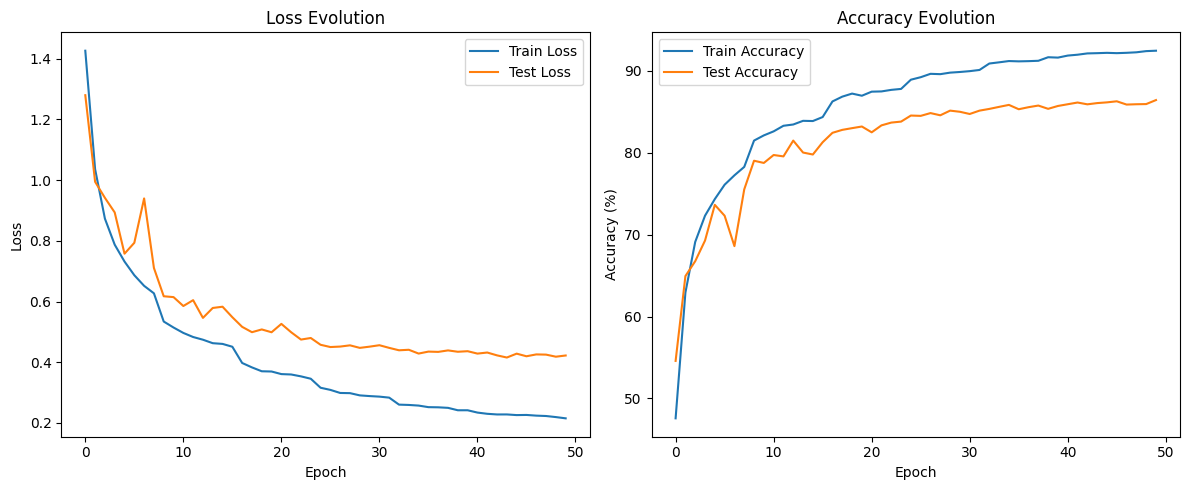

In [2]:
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# Define optimized training function
def train_model(model, trainloader, testloader, num_epochs=50, lr=0.0045, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Loss function and optimizer with learning rate scheduler for improved convergence

    # Define the loss function — CrossEntropyLoss is standard for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # Adam optimizer with initial learning rate and weight decay for regularization
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # Learning rate scheduler: reduces LR by half every 8 epochs to fine-tune the model
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

    scaler = torch.cuda.amp.GradScaler()  # Mixed precision training for speedup

    # Lists to store metrics across epochs
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    start_time = time.time()  # For measuring total training time

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        # TQDM progress bar for real-time feedback
        progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        # Training loop per batch
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Enable automatic mixed precision for forward + backward pass
            with torch.cuda.amp.autocast():
                outputs = model(inputs)         # Forward pass
                loss = criterion(outputs, labels)   # Compute Loss


            # Backpropagation using gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Update running metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            progress_bar.set_postfix(loss=running_loss/total, acc=100.*correct/total)

        scheduler.step()  # Step the scheduler to decay learning rate if necessary

        # Record training performance
        train_losses.append(running_loss / len(trainloader))
        train_accs.append(100. * correct / total)

        # Evaluate on validation data
        model.eval()
        correct, total, test_loss = 0, 0, 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        # Log validation metrics
        test_losses.append(test_loss / len(testloader))
        test_accs.append(100. * correct / total)

        # Print summary for the current epoch
        print(f"Epoch {epoch+1}: Train Acc={train_accs[-1]:.2f}% | Test Acc={test_accs[-1]:.2f}%")

    # Display total training time
    print(f"Total Training Time: {(time.time() - start_time)/60:.2f} minutes")
    return train_losses, test_losses, train_accs, test_accs

# Set training duration and initialize model
num_epochs = 50
model = CNN()
train_losses, test_losses, train_accs, test_accs = train_model(model, trainloader, testloader, num_epochs=num_epochs)

# ---------- Plotting Results ----------

# Create a side-by-side plot of loss and accuracy
plt.figure(figsize=(12,5))

# Plot loss evolution over epochs
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()

# Plot accuracy evolution over epochs
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Evolution')
plt.legend()

# Improve layout and display
plt.tight_layout()
plt.show()
